In [1]:
import os
from data_loaders.document_processor import DocumentProcessor
from dotenv import load_dotenv
load_dotenv()

bot_token = os.getenv("SLACK_BOT_TOKEN")
app_token = os.getenv("SLACK_APP_TOKEN")
if not bot_token or not app_token:
    raise ValueError("Missing Slack tokens in environment variables.")

document_processor = DocumentProcessor('au-blog-rag-fine-tuned')

Index 'au-blog-rag-fine-tuned' loaded.
Total vectors: 940


In [2]:
from data_loaders.sitemap_entry import Sitemap

sitemap = Sitemap(sitemap="https://tech.appunite.com/blog/blog-sitemap.xml")
sitemap_entries = sitemap.load()
print(f"Loaded {len(sitemap_entries)} entries"
      f"")
# print("[")
# for i in sitemap_entries[:15]:
#     print(f"SitemapEntry(url='{i.url}', lastmod=datetime.fromisoformat('{i.lastmod}')),")
# print("]")

Loaded 100 entries


In [3]:
document_processor.update_database(sitemap_entries)

<Skipping> https://tech.appunite.com/blog/one-minor-change-to-regain-your-focus
<Adding> https://tech.appunite.com/blog/modular-software-design-mistakes
<Skipping> https://tech.appunite.com/blog/what-is-mobile-application-maintenance-4-types-of-mobile-application-maintenance
<Skipping> https://tech.appunite.com/blog/mastering-development-process
<Adding> https://tech.appunite.com/blog/integrating-fire-stick-cast-into-android-app-with-chromecast
<Adding> https://tech.appunite.com/blog/git-hub-ci-cd-for-flutter-project
<Skipping> https://tech.appunite.com/blog/focusing-external-teams-members-to-resolve-business-needs
<Adding> https://tech.appunite.com/blog/proposing-architectural-changes
<Adding> https://tech.appunite.com/blog/why-is-qa-important-in-software-development
<Skipping> https://tech.appunite.com/blog/flutter-vs-react-native-which-framework-will-be-best-for-you
<Skipping> https://tech.appunite.com/blog/ecto-s-repo-stream
<Skipping> https://tech.appunite.com/blog/dont-shoot-the-

Found 961 documents.
Unique URLS: 93
Total documents: 961

Total length: 726136
Average length: 755.6045785639958
Max length: 999

Total tokens: 156574
Average tokens: 162.92819979188346
Max tokens: 321


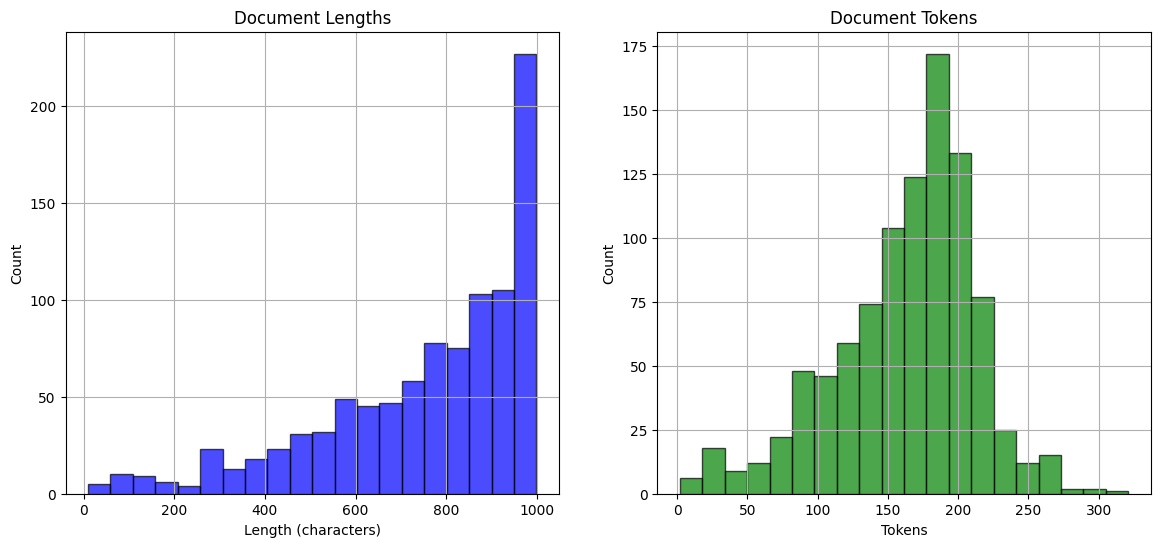

In [4]:
import tiktoken
import matplotlib.pyplot as plt
import pandas as pd 

def count_tokens(text, model="gpt-4o"):
    encoding = tiktoken.encoding_for_model(model)
    t = encoding.encode(text)
    return len(t)

docs = document_processor.get_all_documents()
vector_store_urls = set([doc['metadata']['source'] for doc in docs])
print(f"Unique URLS: {len(vector_store_urls)}")

lengths = [len(doc['content']) for doc in docs]
tokens = [count_tokens(doc['content']) for doc in docs]


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
pd.Series(lengths).hist(bins=20, alpha=0.7, color='blue', edgecolor='black', ax=axes[0])
axes[0].set_title('Document Lengths')
axes[0].set_xlabel('Length (characters)')
axes[0].set_ylabel('Count')

pd.Series(tokens).hist(bins=20, alpha=0.7, color='green', edgecolor='black', ax=axes[1])
axes[1].set_title('Document Tokens')
axes[1].set_xlabel('Tokens')
axes[1].set_ylabel('Count')


print(f"Total documents: {len(lengths)}\n")

print(f"Total length: {sum(lengths)}")
print(f"Average length: {sum(lengths)/len(lengths)}")
print(f"Max length: {max(lengths)}\n")

print(f"Total tokens: {sum(tokens)}")
print(f"Average tokens: {sum(tokens)/len(tokens)}")
print(f"Max tokens: {max(tokens)}")

In [5]:
missing_urls = set([sitemap_entry.url for sitemap_entry in sitemap_entries]) - vector_store_urls

print(f"There are {len(missing_urls)} missing URLs")
for url in missing_urls: 
    print(url)

There are 7 missing URLs
https://tech.appunite.com/blog/a-deep-dive-into-riverpod-vs-bloc
https://tech.appunite.com/blog/how-to-improve-technical-skills-as-a-mobile-app-tester
https://tech.appunite.com/blog/modular-software-design-mistakes
https://tech.appunite.com/blog/how-to-securely-use-google-maps-api-key-in-android-i-os-or-flutter-project
https://tech.appunite.com/blog/proposing-architectural-changes
https://tech.appunite.com/blog/git-hub-ci-cd-for-flutter-project
https://tech.appunite.com/blog/integrating-fire-stick-cast-into-android-app-with-chromecast


In [6]:
from rag_query.query_handler import QueryHandler
import os
from data_loaders.document_processor import DocumentProcessor
from dotenv import load_dotenv
load_dotenv()

bot_token = os.getenv("SLACK_BOT_TOKEN")
app_token = os.getenv("SLACK_APP_TOKEN")
if not bot_token or not app_token:
    raise ValueError("Missing Slack tokens in environment variables.")

document_processor = DocumentProcessor('au-blog-rag-fine-tuned')
rag_system = QueryHandler(
    vectorstore=document_processor.vectorstore,
    pinecone_index=document_processor.pinecone_index,
    dimension=document_processor.dimension
)

Index 'au-blog-rag-fine-tuned' loaded.
Total vectors: 961
Pinecone initialized successfully.


In [10]:
query = "We're discussing with a prospect client that wants to implement an AI feature in the app. Please show me article about our experience and knowledge"
answer = rag_system.get_answer(
    query, 
    filter_false=True, 
    analysis_model="gpt-4o",
    threshold=0.20
)

Retrieved 17 documents

*** Document 1 ***
Source: https://tech.appunite.com/blog/how-agents-are-reshaping-the-future-of-saas-and-business-software-ai
Score: 0.46124491663004363
Page Content: The future of business software lies in specialization, seamless integration, and the transformation of the workforce from manual doers to strategic thinkers. Whether you're an enterprise assessing yo...


*** Document 2 ***
Source: https://tech.appunite.com/blog/google-i-o-2024-keynote-announcements
Score: 0.4307374126431075
Page Content: Available now with Flutter 3.22.

## AI Competition

Custom electric 1981 DeLorean is the grand prize in the AI Competition. All you need to do is build the best app utilizing Gemini API. Additionally...


*** Document 3 ***
Source: https://tech.appunite.com/blog/google-i-o-2024-keynote-announcements
Score: 0.3982984446015861
Page Content: ## Summary

AI was the star of the Google I/O 2024's Keynote. The velocity of improvements and new features introduced for G

In [11]:
for i, doc in enumerate(answer):
    print(f"****** {i + 1} ******\n"
          f"URL: {doc['url']}\n"
          f"Score: {doc['score']}\n"
          f"Decision: {doc['decision']}\n"
          f"Summary: {doc['summary']}\n"
          f"Response: {doc['response']}\n")

****** 1 ******
URL: https://tech.appunite.com/blog/transform-your-app-with-on-device-machine-learning
Score: 0.3371300614965762
Decision: True
Summary: The article discusses the benefits of integrating on-device machine learning (ML) into mobile apps to create innovative, user-focused features. It highlights how on-device ML can enhance app functionality by enabling real-time fraud detection, context-aware marketing, speech analysis, and personalized health monitoring without relying on cloud connectivity. The article also outlines the process of integrating ML models into Flutter apps using TensorFlow Lite, emphasizing the advantages of offline functionality, reduced latency, and enhanced privacy.
Response: The article is relevant as it showcases the company's experience and knowledge in integrating AI features into mobile apps, specifically using on-device ML with Flutter and TensorFlow. This demonstrates their capability to provide innovative solutions for app development.

****** 